In [1]:
# Import libraries
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD

In [2]:
data_path= '/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/unzipped_files/Richards_2017-10-31.tar'

trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
spike_times = np.load(data_path+'/'+'spikes.times.npy') * 1000 # Unbinned spike times in ms
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy') 
trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
spike_clusters = np.load(data_path+'/'+'spikes.clusters.npy')
site_positions = np.load(data_path+'/'+'channels.sitePositions.npy')
clusters_depths = np.load(data_path+'/'+'clusters.depths.npy')
clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
channel_sites = np.load(data_path+'/'+'channels.site.npy')
channels_brainlocation = pd.read_csv(data_path+'/'+'channels.brainLocation.tsv', sep='\t')
clusters_probes = np.load(data_path+'/'+'clusters.probes.npy')
channels_probe = np.load(data_path+'/'+'channels.probe.npy')
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')

visual_times = trials_visual_time
# Behaviour data

wheel_movement = np.load(data_path+'/'+'wheelMoves.type.npy')
wheel_intervals = np.load(data_path+'/'+'wheelMoves.intervals.npy')

# Taken from https://github.com/MouseLand/steinmetz2019_NMA/blob/master/steinmetz_loader.py
# To obtain brain regions
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

# Bin cells according to input bin size

def bin_spikes(spike_times, bin_size = 100):
    
    # Using clusters._phy_annotation.npy obtain valid clusters (i.e. >= 2)
    valid_clusters_idx = np.array(np.where(clusters_annotation>=2))[0]

    spike_time_cells = np.empty(len(valid_clusters_idx), dtype=object) # Initalise empty object
    for i,cell_idx in enumerate(valid_clusters_idx):
      # Create a spike time arrays, where each array in the array is a spike time of a cell
      spike_time_cells[i] = spike_times[(np.where(spike_clusters == cell_idx)[0])]

    # Bin spike times into 10ms intervals
    spike_time_binned = np.empty(len(valid_clusters_idx), dtype=object) # Initalise empty object
    sum_spikes = np.empty(len(valid_clusters_idx), dtype=object) # Initalise empty object

    for cell_num in np.arange(len(spike_time_cells)): 
        spike_time_hist = np.histogram(spike_time_cells[cell_num],bins = np.arange(0,np.floor(spike_time_cells[cell_num][-1]),bin_size))
        spike_time_binned[cell_num] = spike_time_hist[0]
        sum_spikes[cell_num] = np.sum(spike_time_binned[cell_num])

    cell_spikes_max = np.argmax(sum_spikes) # cell with the maximum number of spikes for plotting purposes
    
    # Spike_time_binned returns binned spikes sorted into cells
    # Spike_time_cells returns UNbinned spikes sorted into cells
    # cell_spikes_max returns a single cell index that has the max number of spikes (i.e most active cell)
    return spike_time_binned, spike_time_cells, cell_spikes_max

# Sort cells into trial types and relevant epoch

# (Need to change the sorting into matrices rather than vectors)

def sort_cells_trials(spike_time_binned,spike_time_cells, epoch_duration = 2000 , bin_size = 10):

    # Epoch duration is defined as the period after the visual stimulus

    # Sort into trials
    spike_time_binned_trial = np.empty(len(spike_time_cells), dtype=object)
    spike_time_binned_trial_response = np.empty(len(spike_time_cells), dtype=object)
    for cell_num in np.arange(len(spike_time_cells)):
        spike_time_binned_trial[cell_num] = np.empty(len(trials_intervals), dtype=object)
        spike_time_binned_trial_response[cell_num] = np.empty(len(trials_intervals), dtype=object)
  
        for i,trials_start_end in enumerate(trials_intervals):
            # Sort spikes into their trial numbers. 
            spike_time_binned_trial[cell_num][i] = spike_time_binned[cell_num][ int(np.floor(trials_start_end[0]*(1000/bin_size))) : int(np.floor(trials_start_end[1]*(1000/bin_size)))]
            # Using visual onset to splice a trial into visual onset : visual onset +400ms
            spike_time_binned_trial_response[cell_num][i] = spike_time_binned[cell_num][(int(np.floor(trials_visual_time[i]*(1000/bin_size)))) : (int(np.floor(trials_visual_time[i]*(1000/bin_size)) + epoch_duration))]
            
    # spike_time_binned_trial returns spikes that are sorted into cells and trials
    # spike_time_binned_trial_response returns spikes that are sorted into cells and trials, and spliced accordingly to desired epoch duration post-visual stim onset
    
    return spike_time_binned_trial, spike_time_binned_trial_response

# Sort trials into 3 trial types based on argument (e.g. response_choice, feedback type), left, 

def sort_cells_trial_types(spike_time_binned_trial_response,spike_time_cells):

    # Input: spike_time_binned_trial_response can be any spike_time_binned variable regardless of whether it has been spliced.

    # Get response choice trials types
    right_choice_trials = np.where(trials_response_choice == -1)[0]
    left_choice_trials = np.where(trials_response_choice == 1)[0]
    no_response_choice_trials = np.where(trials_response_choice == 0)[0]

    # Sort trials into response type
    left_spike_time_response = np.empty(len(spike_time_cells), dtype=object)
    right_spike_time_response = np.empty(len(spike_time_cells), dtype=object)
    no_response_spike_time_response = np.empty(len(spike_time_cells), dtype=object)
    
    for cell_num in np.arange(len(spike_time_cells)):
        left_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][left_choice_trials]
        right_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][right_choice_trials]
        no_response_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][no_response_choice_trials]
    
    # Returns 3 variables by sorting the spike_time_binned variable into left, right no response trials
    return left_spike_time_response, right_spike_time_response, no_response_spike_time_response

def sort_cells_brain_regions(spike_time_response, input_region,brain_regions):
    
    regional_spike_time_response = np.empty(len(input_region), dtype=object)
    for i,region in enumerate(input_region):
        # Get brain regions that correponds to the desired region
        brain_region_annotation = clusters_annotation[brain_regions == region]
        # Select only valid regions i.e. annotation >=2
        valid_brain_regions_idx = np.where(brain_region_annotation >= 2)[0]
        # Index the spike time to get spikes from desired regions
        regional_spike_time_response[i] = spike_time_response[valid_brain_regions_idx]
    
    # Merge spikes across all regions
    merged_region_spikes = []
    for i in np.arange(len(regional_spike_time_response)):
        merged_region_spikes = np.append(merged_region_spikes, regional_spike_time_response[i])
    
    # Return spike time sorted into regions and merged across all regions
    # Indexing: regional_spike_times[cell_num][trial_num][# of bins]
    return merged_region_spikes

mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
#all_dat='MOs', 'MRN', 'OLF', 'ORB', 'PAG', 'RSP', 'SCm', 'SCs'

# Concatenate trial epochs into an entire time series 
# e.g. if 400ms/trial were used(260trial x 400bins will be reshaped into 1 x 104 000bins

def concat_trials_2_timeseries(spike_time_response):
    concat_spike_time_response = np.empty(len(spike_time_response), dtype=object)
    
    for cell_num in np.arange(len(spike_time_response)):
        concat_spike_time_response[cell_num] = np.empty(1, dtype=object)
        for trial_num in np.arange(len(spike_time_response[cell_num])):
            concat_spike_time_response[cell_num] = np.append(concat_spike_time_response[cell_num],(spike_time_response[cell_num][trial_num]))
    
    # Return concatenated spike time response 
    # Indexing: spike_times[cell_num][# of bins ]
    return concat_spike_time_response

def reshape_concat(concat_spike_times):
    test_concat_spike_times=[]
    concat_spike_times_=[]
    for j in range(0,concat_spike_times.shape[0]):
        concat_spike_times_.append(concat_spike_times[j][1:10000])
        test_concat_spike_times.append(concat_spike_times[j][10000:20000])
    concat_spike_times_=np.array(concat_spike_times_)
    test_concat_spike_times=np.array(test_concat_spike_times)
    return concat_spike_times_,test_concat_spike_times


In [3]:
def left_right_pca_regression(bs):
    good_cells, brain_regions,br = get_good_cells(data_path) # Get brain regions
    spike_time_binned, spike_time_cells, cell_spikes_max = bin_spikes(spike_times,bin_size=bs)
    spike_time_binned_trial_response, test = sort_cells_trials(spike_time_binned,spike_time_cells,bin_size=bs)
    
    left_spike_time_response, right_spike_time_response, no_response_spike_time_response = sort_cells_trial_types(spike_time_binned_trial_response,spike_time_cells)

    midbrain=['SCs','SCm','MRN','APN','PAG','ZI']
    regional_left_spike_midbrain = sort_cells_brain_regions(left_spike_time_response, midbrain,brain_regions)#'SCm','MRN','APN','PAG','ZI')
    frontal=['MOs','PL','ILA','ORB','MOp','SSp']
    regional_left_spike_frontal = sort_cells_brain_regions(left_spike_time_response, frontal,brain_regions)
    #regional_right_spike=sort_cells_brain_regions(right_spike_time_response,input_regions,brain_regions)#'SCm','MRN','APN','PAG','ZI')
    concat_left_spike_times_midbrain = concat_trials_2_timeseries(regional_left_spike_midbrain)
    concat_left_spike_times_frontal = concat_trials_2_timeseries(regional_left_spike_frontal)
    #concat_right_spike_times=concat_trials_2_timeseries(regional_right_spike)

    concat_left_spike_times_midbrain_,test_midbrain = reshape_concat(concat_left_spike_times_midbrain)
    concat_left_spike_times_frontal_,test_frontal=reshape_concat(concat_left_spike_times_frontal)
    
    from sklearn.decomposition import PCA
    #pritn(left.shape)
    pca=PCA(n_components=10)

    frontal_pcs=pca.fit_transform(concat_left_spike_times_frontal_.T)
    
    
    print('Explained variance',pca.explained_variance_)
    print('Cumulative explained variance:',np.cumsum(pca.explained_variance_))
    #print(frontal_pcs.shape)
    #print(concat_left_spike_times_midbrain_.shape)
    from sklearn.linear_model import Ridge
    clf = Ridge(alpha=1.0)
    clf.fit(frontal_pcs, concat_left_spike_times_midbrain_.T)
    
    #print(test_frontal.shape)
    test_pcs=pca.transform(test_frontal.T)
    
    prediction=clf.predict(test_pcs)
    
    #print('prediction',prediction.shape)
    
    #print('midbrain',test_midbrain.shape)
    from scipy.stats import pearsonr
    r_lst=[]
    for j in range(0,193):
        #print(pearsonr(np.array(prediction.T[j,:]).flatten(),test_midbrain[j,:].flatten())[0])
        r_lst.append(pearsonr(np.array(prediction.T[j,:]).flatten(),test_midbrain[j,:].flatten())[0])
    print('how many cells with corr coef larger than 0.3: ', np.sum(np.array(r_lst)>=0.3))
    plt.hist(r_lst)
    
    #plt.scatter(prediction,test_midbrain)
    
    return clf.coef_
    

    

Explained variance [0.31217416 0.11826257 0.07597825 0.07364004 0.07343913 0.06971321
 0.06852295 0.06626792 0.05943957 0.05832035]
Cumulative explained variance: [0.31217416 0.43043674 0.50641498 0.58005502 0.65349415 0.72320736
 0.79173031 0.85799823 0.9174378  0.97575815]


/home/maria/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


how many cells with corr coef larger than 0.3:  16


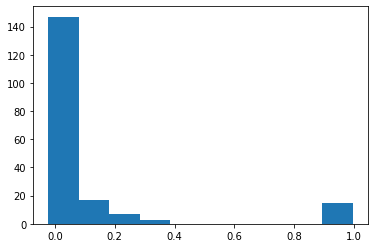

In [4]:
#Whole brain: 'MOs', 'MRN', 'OLF', 'ORB', 'PAG', 'RSP', 'SCm', 'SCs'
#midbrain 'SCs','SCm','MRN','APN','PAG','ZI'
#frontal 'MOs','PL','ILA','ORB','MOp','SSp'

weight_matrix=left_right_pca_regression(10)

In [19]:
def left_right_raw_regression(bs):
    good_cells, brain_regions,br = get_good_cells(data_path) # Get brain regions
    spike_time_binned, spike_time_cells, cell_spikes_max = bin_spikes(spike_times,bin_size=bs)
    spike_time_binned_trial_response, test = sort_cells_trials(spike_time_binned,spike_time_cells,bin_size=bs)
    
    left_spike_time_response, right_spike_time_response, no_response_spike_time_response = sort_cells_trial_types(spike_time_binned_trial_response,spike_time_cells)

    midbrain=['SCs','SCm','MRN','APN','PAG','ZI']
    regional_left_spike_midbrain = sort_cells_brain_regions(left_spike_time_response, midbrain,brain_regions)#'SCm','MRN','APN','PAG','ZI')
    frontal=['MOs','PL','ILA','ORB','MOp','SSp']
    regional_left_spike_frontal = sort_cells_brain_regions(left_spike_time_response, frontal,brain_regions)
    #regional_right_spike=sort_cells_brain_regions(right_spike_time_response,input_regions,brain_regions)#'SCm','MRN','APN','PAG','ZI')
    concat_left_spike_times_midbrain = concat_trials_2_timeseries(regional_left_spike_midbrain)
    concat_left_spike_times_frontal = concat_trials_2_timeseries(regional_left_spike_frontal)
    #concat_right_spike_times=concat_trials_2_timeseries(regional_right_spike)

    concat_left_spike_times_midbrain_,test_midbrain = reshape_concat(concat_left_spike_times_midbrain)
    concat_left_spike_times_frontal_,test_frontal=reshape_concat(concat_left_spike_times_frontal)
    
    #from sklearn.decomposition import PCA
    #pritn(left.shape)
    #pca=PCA(n_components=10)

    #frontal_pcs=pca.fit_transform(concat_left_spike_times_frontal_.T)
    
    
    #print('Explained variance',pca.explained_variance_)
    #print('Cumulative explained variance:',np.cumsum(pca.explained_variance_))
    #print(frontal_pcs.shape)
    #print(concat_left_spike_times_midbrain_.shape)
    from sklearn.linear_model import Ridge
    clf = Ridge(alpha=1.0)
    clf.fit(concat_left_spike_times_frontal_.T, concat_left_spike_times_midbrain_.T)
    
    #print(test_frontal.shape)
    #test_pcs=pca.transform(test_frontal.T)
    
    prediction=clf.predict(test_frontal.T)
    
    #print('prediction',prediction.shape)
    
    #print('midbrain',test_midbrain.shape)
    from scipy.stats import pearsonr
    r_lst=[]
    for j in range(0,193):
        #print(pearsonr(np.array(prediction.T[j,:]).flatten(),test_midbrain[j,:].flatten())[0])
        r_lst.append(pearsonr(np.array(prediction.T[j,:]).flatten(),test_midbrain[j,:].flatten())[0])
    print('how many cells with corr coef larger than 0.3: ', np.sum(np.array(r_lst)>=0.3))
    plt.hist(r_lst)
    plt.title('correlation for ridge')
    plt.show()
    
    #plt.scatter(prediction,test_midbrain)
    
    from sklearn.linear_model import Lasso
    clf_l = Lasso(alpha=0.1)
    clf_l.fit(concat_left_spike_times_frontal_.T, concat_left_spike_times_midbrain_.T)
    
    #print(test_frontal.shape)
    #test_pcs=pca.transform(test_frontal.T)
    
    prediction_l=clf_l.predict(test_frontal.T)
    
    #print('prediction',prediction.shape)
    
    #print('midbrain',test_midbrain.shape)
    from scipy.stats import pearsonr
    r_lst=[]
    for j in range(0,193):
        #print(pearsonr(np.array(prediction.T[j,:]).flatten(),test_midbrain[j,:].flatten())[0])
        r_lst.append(pearsonr(np.array(prediction_l.T[j,:]).flatten(),test_midbrain[j,:].flatten())[0])
    print('how many cells with corr coef larger than 0.3: ', np.sum(np.array(r_lst)>=0.3))
    plt.hist(r_lst)
    plt.title('correlation for lasso')
    
    plt.show()
    
    return clf.coef_, clf_l.coef_

/home/maria/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


how many cells with corr coef larger than 0.3:  176


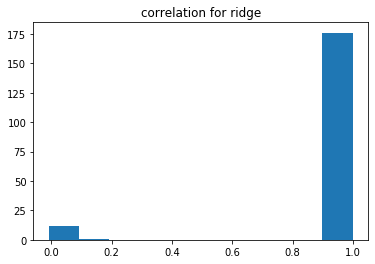

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/home/maria/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


how many cells with corr coef larger than 0.3:  0


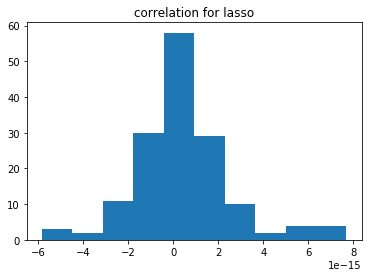

In [20]:
weight_matrix_ridge,weight_matrix_lasso=left_right_raw_regression(10)